## Download data and install package

In [1]:
!gdown --id "1vqsjGzGZnpCEgHliEsVmAvzm9_1h3L-Y&export=download"
!unrar x -Y "/Users/ngocanh/Downloads/Lab/CTAI-ML/ML-exercises/Ex17/lab1.rar" -d "/content/"

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vqsjGzGZnpCEgHliEsVmAvzm9_1h3L-Y&export=download
To: /Users/ngocanh/Ex17/lab1.rar
100%|███████████████████████████████████████| 50.0k/50.0k [00:00<00:00, 812kB/s]
zsh:1: command not found: unrar


## Build a graph

In [2]:
import networkx as nx
import numpy as np
import torch

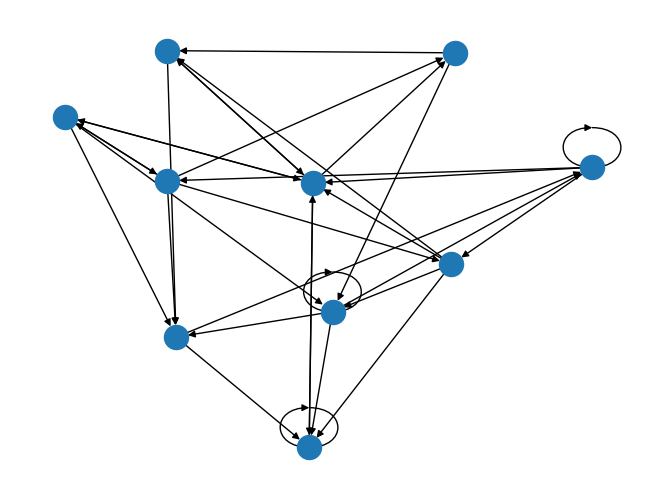

In [12]:
G1 = nx.read_edgelist('lab1_small_edgelist.txt', create_using = nx.DiGraph(), nodetype = None, data = [('weight', int)])
nx.draw(G1)

In [13]:
A_torch = torch.randint(0, 2, (10, 10))
A_np = np.random.randint(2, size = (15, 15))

def build_graph(adj_matrix):
    graph = nx.DiGraph()  # note nx.Graph() v.s. nx.DiGraph()
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix[i])):
            if adj_matrix[i][j] == 1:
                graph.add_edge(i, j)
            if i == j:
                graph.add_edge(i, j)
    return graph

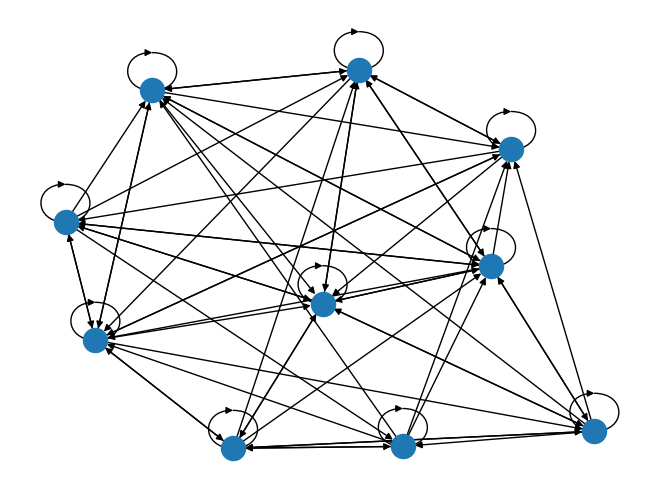

In [14]:
G2 = build_graph(A_torch)
nx.draw(G2)

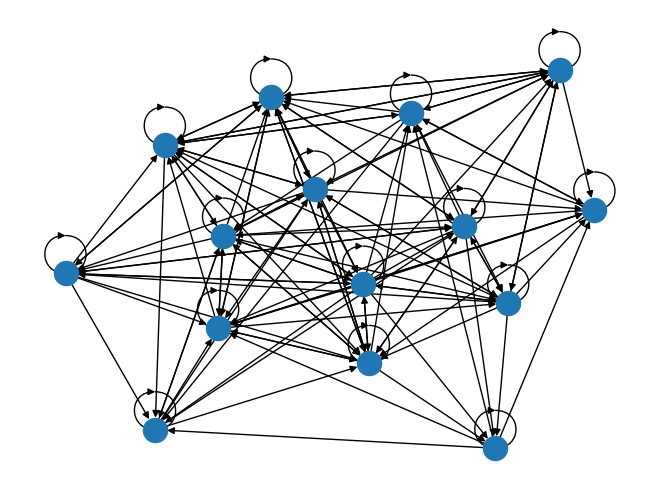

In [15]:
G3 = build_graph(A_np)
nx.draw(G3)

## Implement DeepWalk

In [10]:
import networkx as nx
from joblib import Parallel, delayed
import random
import itertools
import numpy as np
from gensim.models import Word2Vec

In [17]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

In [ ]:
class RandomWalker:
  def __init__(self, G, num_walks, walk_length):
      """
      :param G: Graph
      :param num_walks: a number of walks per vertex
      :param walk_length: Length of a walk. Each walk is considered as a sentence
      """
      self.G = G
      self.num_walks = num_walks
      self.walk_length = walk_length


  def deepwalk_walk(self, start_node):
      """
      :param start_node: Starting node of a walk
      """
      walk = [start_node]
      while len(walk) < self.walk_length:
          cur = walk[-1]
          # Check if having any neighbors at the current node
          cur_nbrs = list(self.G.neighbors(cur))
          if len(cur_nbrs) > 0:
              # Random walk with the probability of 1/d(v^t). d(v^t) is the node degree
              walk.append(random.choice(cur_nbrs))
          else:
              break
      return walk


  def simulate_walks(self, workers = 1, verbose = 0):
      """
      :param workers: a number of workers running in parallel processing
      :param verbose: progress bar
      """
      G = self.G
      nodes = list(G.nodes())
      results = Parallel(n_jobs = workers, verbose = verbose)(
          delayed(self._simulate_walks)(nodes) for num in
          partition_num(self.num_walks, workers))
      walks = list(itertools.chain(*results))
      return walks

  # INFORMATION EXTRACTOR
  def _simulate_walks(self, nodes):
      walks = []
      # Iterate all walks per vertex
      for _ in range(self.num_walks):
          random.shuffle(nodes)
          # Iterate all nodes in a walk
          for v in nodes:
            walks.append(self.deepwalk_walk(start_node=v))
      return walks

In [33]:
class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, workers = 1):

        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}

        self.walker = RandomWalker(graph, num_walks = num_walks, walk_length = walk_length)
        self.sentences = self.walker.simulate_walks(workers = workers, verbose = 1)

    def train(self, vector_size = 128, window_size = 5, workers = 1, epochs = 5, **kwargs):

        kwargs["sentences"] = self.sentences
        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["vector_size"] = vector_size
        kwargs["sg"] = 1  # skip gram
        kwargs["hs"] = 1  # deepwalk use Hierarchical Softmax
        kwargs["workers"] = workers
        kwargs["window"] = window_size
        kwargs["epochs"] = epochs

        print("Learning embedding vectors...")
        model = Word2Vec(**kwargs) # Pay attention here
        print("Learning embedding vectors done!")

        self.w2v_model = model
        return model

    def get_embeddings(self,):
        if self.w2v_model is None:
            print("model not train")
            return {}

        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]

        return self._embeddings

In [34]:
G = nx.read_edgelist('lab1_big_edgelist.txt',create_using = nx.DiGraph(), nodetype = None, data = [('weight', int)])# Read graph
model = DeepWalk(G, walk_length = 10, num_walks = 80, workers = 1)#init model
model.train(vector_size = 5, epochs = 3) # train model
embeddings = model.get_embeddings()# get embedding vectors

Learning embedding vectors...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Learning embedding vectors done!


In [35]:
count = 0
for i, (k, v) in enumerate(embeddings.items()):
  print("Index {} has key {} and value {}".format(str(i), k, v))
  count += 1
  if count == 2:
    break

Index 0 has key 1397 and value [ 0.9836712   0.4856427   0.46850303  0.19946548 -0.33526894]
Index 1 has key 1470 and value [ 1.6335144   0.13300137  0.59555364  0.03538678 -0.24453235]
